# CMSC320 Final Project


Column:  Index ----- Number of NaN:  0
Column:  Date ----- Number of NaN:  0
Column:  U.S. Airline Traffic - Total - Seasonally Adjusted ----- Number of NaN:  65
Column:  Transit Ridership - Other Transit Modes - Adjusted ----- Number of NaN:  12
Column:  Transit Ridership - Fixed Route Bus - Adjusted ----- Number of NaN:  12
Column:  Transit Ridership - Urban Rail - Adjusted ----- Number of NaN:  12
Column:  Highway Fuel Price - Regular Gasoline ----- Number of NaN:  10
Column:  Passenger Rail Passengers ----- Number of NaN:  16
Column:  Passenger Rail Total Train Miles ----- Number of NaN:  16
Column:  Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted ----- Number of NaN:  89
Total NaN:  232
Gas Prices Missing:   0


/var/folders/kt/bb0_zk5n4x1g8hsp0gmxbnsm0000gn/T/ipykernel_91267/1508718961.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])


([<matplotlib.patches.Wedge at 0x13a263b60>,
 [Text(1.1, 0.0, 'Index'),
  Text(1.1, 0.0, 'Date'),
  Text(0.7007071706189039, 0.847944255858397, 'U.S. Airline Traffic - Total - Seasonally Adjusted'),
  Text(-0.37933091810789465, 1.0325250866528242, 'Transit Ridership - Other Transit Modes - Adjusted'),
  Text(-0.6891610516871217, 0.8573546785534565, 'Transit Ridership - Fixed Route Bus - Adjusted'),
  Text(-0.9268402198951537, 0.5924248532807375, 'Transit Ridership - Urban Rail - Adjusted'),
  Text(-1.0599049874572877, 0.29428118791925323, 'Highway Fuel Price - Regular Gasoline'),
  Text(-1.096371325647739, -0.08927438768997302, 'Passenger Rail Passengers'),
  Text(-0.9575541834970063, -0.5413778584938451, 'Passenger Rail Total Train Miles'),
  Text(0.39327745424037824, -1.0272939423486382, 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted')],
 [Text(0.6, 0.0, '0%'),
  Text(0.6, 0.0, '0%'),
  Text(0.3822039112466748, 0.4625150486500346, '28%'),

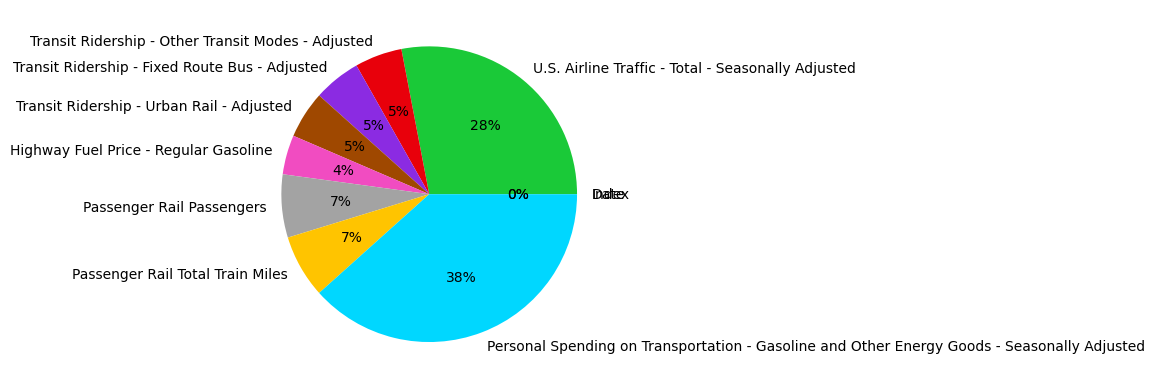

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


transportation_df = pd.read_csv('Monthly_Transportation_Statistics.csv')
gasprices_df = pd.read_csv('USGasanddieselprices.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
#print(list(transportation_df.columns))
transportation_df = transportation_df[['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']]
gasprices_df = gasprices_df[['Date', 'A1']]
transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
transportation_df = transportation_df.loc[transportation_df['Date'] >= '01-01-1975']
transportation_df.head()


total_nan = 0
for curr in range(0, len(transportation_df.columns)):
    print("Column: ", transportation_df.columns[curr] , "----- Number of NaN: ", transportation_df.iloc[:, curr].isnull().sum())
    total_nan += transportation_df.iloc[:, curr].isnull().sum()

print('Total NaN: ', total_nan)
print('Gas Prices Missing:  ', gasprices_df.loc[:, 'A1'].isnull().sum())

#print(transportation_df.isna().sum())

colors = sns.color_palette('bright')[0:10]
plt.pie(x = transportation_df.isnull().sum(), labels = transportation_df.isnull().sum().index, colors = colors, autopct='%.0f%%')

#gasprices_df.head


    

We have two datasets, one is for transportation, another is for gas prices specifically. As the chart above demonstrates, there is a lot of data missing in the transportation dataframe especially from airline traffic and personal spending on transportation. Looking at the dataframes themselves, one can notice that for all missing data, the data is not missing after a certain date, meaning that the data is missing not at random (MNAR) because there is a clear time frame where the data is missing. In fact, none of the choosen columns have any data before 1975. The gas dataframe on the other hand, has no prices missing as we are using the "All Grades All Formulations Gasoline Prices" column only for simplicity. 